In [1]:
import os

import numpy as np
import pandas as pd
import cuml
from sentence_transformers import SentenceTransformer

N_HEADLINES = 10000

model = SentenceTransformer('all-MiniLM-L6-v2')
df = pd.read_csv("kaggle_million_headlines.zip")
embeddings = model.encode(df.headline_text[:N_HEADLINES])

/root/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
umap = cuml.manifold.UMAP(n_components=5, n_neighbors=15, min_dist=0.0, random_state=12)
reduced_data = umap.fit_transform(embeddings)

In [3]:
clusterer = cuml.cluster.hdbscan.HDBSCAN(min_cluster_size=50, metric='euclidean', prediction_data=True)
clusterer.fit(reduced_data)
soft_clusters = cuml.cluster.hdbscan.all_points_membership_vectors(clusterer)
soft_clusters[0]

array([0.01570771, 0.01076699, 0.02277696, 0.01951891, 0.0137632 ,
       0.02145931, 0.02255244, 0.03296046, 0.02833972, 0.05513387,
       0.02559628, 0.02096902, 0.03881368, 0.04205474, 0.05579055,
       0.06135306, 0.01828161, 0.02769018, 0.02380901, 0.01644669],
      dtype=float32)

In [10]:
soft_clusters.shape

(10000, 20)

In [9]:
clusterer.fit_predict(reduced_data)

array([-1, -1, -1, ..., 14, -1, 18], dtype=int32)

In [4]:
pd.Series(clusterer.labels_).value_counts()

-1     4043
 3     1981
 5     1029
 16     689
 18     341
 13     236
 7      218
 8      210
 2      191
 0      191
 14     149
 19      90
 15      86
 10      80
 17      77
 4       68
 6       67
 11      66
 9       66
 12      61
 1       61
dtype: int64

In [5]:
df[:N_HEADLINES].loc[clusterer.labels_ == 8].headline_text.head()

94                       mayor warns landfill protesters
334                        more anti war rallies planned
362         pm criticism of protesters disgraceful crean
363          pm defends criticism of anti war protesters
372    politicians breeding publics anti troop sentiment
Name: headline_text, dtype: object

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# get the difference between top two membership probabilities for each record (exclude noise)
soft_non_noise = soft_clusters[clusterer.labels_ != -1]
probs_top2_non_noise = np.take_along_axis(soft_non_noise, soft_non_noise.argsort(), axis=1)[:, -2:]
diffs = np.diff(probs_top2_non_noise).ravel()

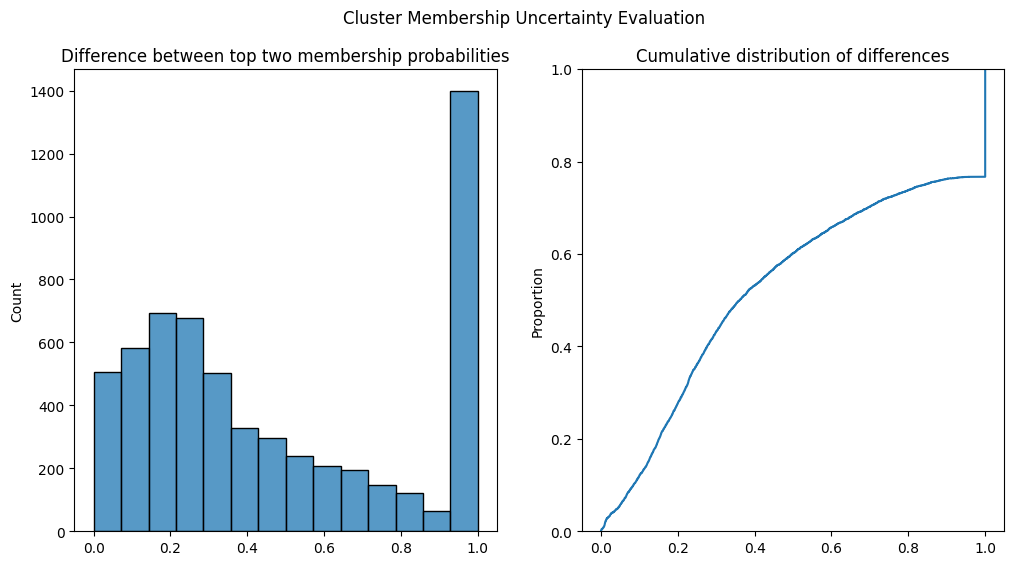

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
fig.suptitle('Cluster Membership Uncertainty Evaluation')

sns.histplot(ax=axes[0], data=diffs)
axes[0].set_title("Difference between top two membership probabilities")

sns.ecdfplot(ax=axes[1], data=diffs)
axes[1].set_title("Cumulative distribution of differences")

fig.savefig("soft-clustering-importance-diffs-cdf.png")